#Clustering Music Venues in São Paulo

This notebook presents a cluster analysis of music venues in São Paulo. By taking into account location and category of said music venues, the analysis aims at providing a general overview and some insights on the current state of the live music scene in the city. 

#1. Getting geographical data 
In this analysis We will be working basically with two types of data: geographical coordinates of all districts in São Paulo, and music venues in São Paulo along with its correspondent categories.

After importing the necessary libraries for this first step, let's proceed  with the data.

In [ ]:
import pandas as pd
import numpy as np
import json
import requests
from pandas.io.json import json_normalize

##1.1 São Paulo's districts data
The geographical coordinates of São Paulo's districts will be imported from [this JSON file](https://www.kaggle.com/caiobsilva/sp-district-coordinates) available in Kaggle.

Let's convert the data into a dataframe and have a quick look at it.

In [ ]:
sp_districts = pd.read_json('https://raw.githubusercontent.com/PriscilaBrito/coursera_capstone/master/sp_dist.json')
sp_districts.head()

,Districts,Population,Longitude,Latitude
1,Grajaú,444.593,-46.665575,-23.785798
2,Sapopemba,296.042,-46.509885,-23.604326
3,Jardim Ângela,291.798,-46.771206,-23.712246
4,Brasilândia,280.069,-46.690269,-23.448272
5,Capão Redondo,275.230,-46.767753,-23.658859


In [ ]:
sp_districts.shape

(96, 4)

As we can see, the file contains the geographical coordinates of all 96 districts in São Paulo, plus the corresponding population in each of them. Since we won't need population data for this analysis, let's drop this column.

In [ ]:
sp_districts.drop(columns=['Population'], axis = 1, inplace = True)
sp_districts

,Districts,Longitude,Latitude
1,Grajaú,-46.665575,-23.785798
2,Sapopemba,-46.509885,-23.604326
3,Jardim Ângela,-46.771206,-23.712246
4,Brasilândia,-46.690269,-23.448272
5,Capão Redondo,-46.767753,-23.658859
...,...,...,...
92,Jaguara,-46.755315,-23.507446
93,Sé,-46.633446,-23.550443
94,Pari,-46.615849,-23.532976
95,Barra Funda,-46.667513,-23.525462


Also, let's just rearrange the coordinates columns and use the standard order (latitude first, then longitude). 

In [ ]:
sp_districts = sp_districts[['Districts', 'Latitude', 'Longitude']]
sp_districts.head()

,Districts,Latitude,Longitude
1,Grajaú,-23.785798,-46.665575
2,Sapopemba,-23.604326,-46.509885
3,Jardim Ângela,-23.712246,-46.771206
4,Brasilândia,-23.448272,-46.690269
5,Capão Redondo,-23.658859,-46.767753


###1.1.2 Plotting the data
In order to check if the coordinates are accurate, let's plot the data into a map.

We'll import a few more libraries that will be needed for this step and for further ones.



In [ ]:
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
 
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
 
# import k-means from clustering stage
from sklearn.cluster import KMeans
 
!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library
 
print('Libraries imported.')

/bin/bash: conda: command not found
/bin/bash: conda: command not found
Libraries imported.


Let's get the geographical coordinates of São Paulo and then plot the map with this information and the previous data on the city's districts.

In [ ]:
address = 'São Paulo, SP'
 
geolocator = Nominatim(user_agent="sp_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of São Paulo are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of São Paulo are -23.5506507, -46.6333824.


In [ ]:
# create map of São Paulo using latitude and longitude values
map_sp_districts = folium.Map(location=[latitude, longitude], zoom_start=11)
 
# add markers to map
for lat, lng, label in zip(sp_districts['Latitude'], sp_districts['Longitude'], sp_districts['Districts']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sp_districts)  
    
map_sp_districts

##1.2 Getting music venues data
Now it's time to get the music venues data. We'll be using Foursquare API for this step.

In [ ]:
CLIENT_ID = 'LDR345YG0L5P213LREBTRYKQM0JY2KJR5KRORHMTOLX4XDJL' 
CLIENT_SECRET = 'ZVZX1NX1YZXRRQQ4TFWUIJX1MWCWKNJR2BXSXVQRSFYXR2JG'
VERSION = '20180605' # Foursquare API version
 
print('Credentails defined')

Credentails defined


###1.2.1 Defining search parameters
We are now going to define some parameters for our Foursquare search, such as geographical coordinates and radius. Then, we are going to create a function that will search for some specific music venues categories. 


Foursquare have several venues related to music, like music schools, karaoke bars and so on. But since we are interested in getting to know the city's live music scene, we'll be limiting the scope to music venues were musicians perform live.


Therefore, we'll be retrieving music venues in São Paulo in the following nine categories: Amphitheater, Concert Hall, Music Venue, Jazz Club, Piano Bar, Rock Club, Music Festival, Nightlife Spot and Nightclub.


In [ ]:
LIMIT = 50
radius = 10000
latitude_sp = -23.5506507
longitude_sp = -46.6333824

In [ ]:
def create_url(endpoint, CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, categoryId):
    url = '{}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            endpoint,
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            categoryId,
            LIMIT
        )
    return url

endpoint = 'https://api.foursquare.com/v2/venues/search?'
categoryIds = ['56aa371be4b08b9a8d5734db', # Amphitheater
               '5032792091d4c4b30a586d5c', # Concert Hall
               '4bf58dd8d48988d1e5931735', # Music Venue
               '4bf58dd8d48988d1e7931735', # Jazz Club
               '4bf58dd8d48988d1e8931735', # Piano Bar
               '4bf58dd8d48988d1e9931735', # Rock Club
               '5267e4d9e4b0ec79466e48d1', # Music Festival
               '4d4b7105d754a06376d81259', # Nightlife Spot
               '4bf58dd8d48988d11f941735', # Nightclub
              ]
VERSION = 20180405
LIMIT = 50
radius = 10000
lat = -23.5506507
lng = -46.6333824
categoryId = ','.join(categoryIds)
url_example = create_url(endpoint, CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, categoryId)
print(url_example)

https://api.foursquare.com/v2/venues/search?&client_id=LDR345YG0L5P213LREBTRYKQM0JY2KJR5KRORHMTOLX4XDJL&client_secret=ZVZX1NX1YZXRRQQ4TFWUIJX1MWCWKNJR2BXSXVQRSFYXR2JG&v=20180405&ll=-23.5506507,-46.6333824&radius=10000&categoryId=56aa371be4b08b9a8d5734db,5032792091d4c4b30a586d5c,4bf58dd8d48988d1e5931735,4bf58dd8d48988d1e7931735,4bf58dd8d48988d1e8931735,4bf58dd8d48988d1e9931735,5267e4d9e4b0ec79466e48d1,4d4b7105d754a06376d81259,4bf58dd8d48988d11f941735&limit=50


Let's now match all the venues retrieved to neighborhoods, then create a dataframe with the results.

In [ ]:
def getNearby(neighborhoods, latitudes, longitudes, radius=1000):
    endpoint = endpoint = 'https://api.foursquare.com/v2/venues/search?'
    venues_list = []
    
    for hood_name, lat, lng, in zip(neighborhoods, latitudes, longitudes):
        url = create_url(endpoint, CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, categoryId)
        
        results = requests.get(url).json()['response']['venues']
        
        for item in results:
            venue_name = item['name']
            venue_id = item['id']
            venue_category = item['categories'][0]['name']
            venue_lat = item['location']['lat']
            venue_lng = item['location']['lng']
            category_id = item['categories'][0]['id']
            try:
                venue_city = item['location']['city']
            except:
                venue_city = 'N/A'
                        
            venues_list.append([(hood_name,
                                lat,
                                lng,
                                venue_name,
                                venue_id,
                                category_id,
                                venue_category,
                                venue_lat,
                                venue_lng,
                                venue_city
                               )])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                             'Neighborhood Latitude',
                             'Neighborhood Longitude',
                             'Venue Name',
                             'Venue ID',
                             'Category ID',
                             'Venue Category',
                             'Venue Latitude',
                             'Venue Longitude', 
                             'Venue City' 
                             ]
    return nearby_venues

sp_music_venues = getNearby(sp_districts['Districts'],
                            sp_districts['Latitude'],
                            sp_districts['Longitude'])

In [ ]:
sp_music_venues.to_csv('new_sp_music_venues.csv', index=False)

In [ ]:
new_sp_music_venues = pd.read_csv('new_sp_music_venues.csv')

##2. Data Preparation

Now that we have gathered the necessary data, it's time to clean it and prepare it for the analysis. We'll start by taking a closer look at the music venues dataframe, the number of venues and categories that were retrieved. 

In [ ]:
new_sp_music_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Name,Venue ID,Category ID,Venue Category,Venue Latitude,Venue Longitude,Venue City
0,Sapopemba,-23.604327,-46.509885,Bar do Rock,4eace4d86da1a0e3a44720a2,4bf58dd8d48988d116941735,Bar,-23.604877,-46.509026,São Paulo
1,Sapopemba,-23.604327,-46.509885,Willie Dixon,4f2c9904e4b0124ab79ff557,4bf58dd8d48988d116941735,Bar,-23.604973,-46.508946,São Paulo
2,Sapopemba,-23.604327,-46.509885,Amorin's Escola de Musica E Artes,4f720b8be4b09a109634ca37,4bf58dd8d48988d1e5931735,Music Venue,-23.600253,-46.516090,NaN
3,Sapopemba,-23.604327,-46.509885,Retrô Bar e Lanches,577ac990cd108f2f161b6704,4bf58dd8d48988d116941735,Bar,-23.614113,-46.511894,São Paulo
4,Sapopemba,-23.604327,-46.509885,Faive - Boate do Di,5039b27ce4b03fdd88e3f1a8,4bf58dd8d48988d11f941735,Nightclub,-23.604420,-46.514323,NaN


In [ ]:
new_sp_music_venues.shape

(3522, 10)

In [ ]:
print('There are {} unique categories.'.format(len(new_sp_music_venues['Venue Category'].unique())))

There are 95 unique categories.


In [ ]:
print('There are {} unique venues.'.format(len(new_sp_music_venues['Venue Name'].unique())))

There are 3243 unique venues.


###2.1 Data Cleaning

As aforementioned, we wanted to retrieve music venues in nine music categories. However, 95 categories were retrieved by Foursquare API. And there are more than 3,000 unique venues. It seems like the search went too far.

Let's check the categories and verify if all of them correspond to venues based in São Paulo. Let's also look for any missing values in the dataframe.

In [ ]:
new_sp_music_venues.groupby('Venue Category')['Venue Category'].count().sort_values

<bound method Series.sort_values of Venue Category
Airport Lounge                    1
Amphitheater                      6
Argentinian Restaurant            1
BBQ Joint                         6
Baiano Restaurant                 1
                                 ..
Vegetarian / Vegan Restaurant     1
Whisky Bar                       14
Wine Bar                         28
Wine Shop                         4
Wings Joint                       1
Name: Venue Category, Length: 95, dtype: int64>

In [ ]:
new_sp_music_venues.groupby('Venue City')['Venue City'].count().sort_values

<bound method Series.sort_values of Venue City
Aldeia                               1
Amparo                               1
Anywhere                             1
Barretos                             1
Brasilia, Brazil                     1
Campinas                             2
Carapicuíba                          1
Espírito Santo do Pinhal             7
Fake London                          1
Fernandópolis                        1
Guarulhos                            3
Ipiranga                             1
Itu                                  1
Jundiaí                              1
Mairiporã                            1
OZ                                   1
Osasco                              11
Pedreira                            11
Pirituba                             2
S. Paulo                             1
SP                                   3
SP -SP                               1
Santo André                          2
Sao Pauli                            1
Sau Paolo        

In [ ]:
new_sp_music_venues.isnull().values.any()

True

###2.1.2 Removing data
We'll have to remove all the venue data that is not related to venues in São Paulo nor to the music venues categories that we've established earlier.

In [ ]:
sp_venues = new_sp_music_venues[(new_sp_music_venues['Venue City']=='São Paulo')]
delta = new_sp_music_venues.shape[0] - sp_venues.shape[0]
print (f'{delta} entries were removed from the preliminary dataset based on "Venue City"')
sp_venues.head()

1514 entries were removed from the preliminary dataset based on "Venue City"


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Name,Venue ID,Category ID,Venue Category,Venue Latitude,Venue Longitude,Venue City
0,Sapopemba,-23.604327,-46.509885,Bar do Rock,4eace4d86da1a0e3a44720a2,4bf58dd8d48988d116941735,Bar,-23.604877,-46.509026,São Paulo
1,Sapopemba,-23.604327,-46.509885,Willie Dixon,4f2c9904e4b0124ab79ff557,4bf58dd8d48988d116941735,Bar,-23.604973,-46.508946,São Paulo
3,Sapopemba,-23.604327,-46.509885,Retrô Bar e Lanches,577ac990cd108f2f161b6704,4bf58dd8d48988d116941735,Bar,-23.614113,-46.511894,São Paulo
5,Sapopemba,-23.604327,-46.509885,Buffet Spazio Felicitta,4f8a1a1ee4b013a9812ba092,4bf58dd8d48988d11f941735,Nightclub,-23.602036,-46.512715,São Paulo
9,Sapopemba,-23.604327,-46.509885,Andrew's Home Sweet Home,4fd6c00dc2ee1b7346fc1612,4bf58dd8d48988d11e941735,Cocktail Bar,-23.602481,-46.511658,São Paulo


In [ ]:
music_venues = ['Amphitheater', 'Concert Hall', 'Music Venue', 'Jazz Club', 'Piano Bar', 'Rock Club', 'Music Festival', 'Nightlife Spot', 'Nightclub']
sp_only_music_venues = sp_venues[sp_venues['Venue Category'].isin(music_venues)]
delta = sp_venues.shape[0] - sp_only_music_venues.shape[0]
print(f'{delta} entries were removed based on "Venue Category" not being related to music')
sp_only_music_venues.head()

1724 entries were removed based on "Venue Category" not being related to music


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Name,Venue ID,Category ID,Venue Category,Venue Latitude,Venue Longitude,Venue City
5,Sapopemba,-23.604327,-46.509885,Buffet Spazio Felicitta,4f8a1a1ee4b013a9812ba092,4bf58dd8d48988d11f941735,Nightclub,-23.602036,-46.512715,São Paulo
33,Sapopemba,-23.604327,-46.509885,Mv Studio,4f84df04e4b04b40a8fd922d,4bf58dd8d48988d1e9931735,Rock Club,-23.610153,-46.511442,São Paulo
34,Sapopemba,-23.604327,-46.509885,Goma,58375fb68ee5606e0cc8acb8,4bf58dd8d48988d1e5931735,Music Venue,-23.610996,-46.520664,São Paulo
35,Sapopemba,-23.604327,-46.509885,Casa De Show,59546aba81348872d4c82335,4bf58dd8d48988d1e5931735,Music Venue,-23.595633,-46.503965,São Paulo
56,Capão Redondo,-23.658859,-46.767753,Buteco Estação da Vila,5ee1485894aa89349a4ff169,4bf58dd8d48988d1e5931735,Music Venue,-23.658214,-46.767071,São Paulo


###2.3 Plotting music venues data
Let's check if now we have only the desired venue categories, then proceed with a quick exploratory analysis of our findings, and finally plot the music venues data into a map.

In [ ]:
print('There are {} unique categories.'.format(len(sp_only_music_venues['Venue Category'].unique())))

There are 8 unique categories.


In [ ]:
sp_only_music_venues.groupby('Venue Category')['Venue Category'].count().sort_values

<bound method Series.sort_values of Venue Category
Amphitheater       3
Concert Hall      37
Jazz Club          5
Music Venue       96
Nightclub         98
Nightlife Spot     9
Piano Bar          3
Rock Club         33
Name: Venue Category, dtype: int64>

As we can see by the series above, although we were searching for nine specific music venue categories, Foursquare API managed to retrieve only eight categories in São Paulo. The non-found category is "Music Festival".

In [ ]:
print('There are {} unique venues.'.format(len(sp_only_music_venues['Venue Name'].unique())))

There are 267 unique venues.


In [ ]:
sp_only_music_venues.groupby('Neighborhood')['Neighborhood'].count().sort_values

<bound method Series.sort_values of Neighborhood
Alto de Pinheiros     4
Anhanguera            1
Aricanduva            1
Artur Alvim           2
Barra Funda          12
                     ..
Vila Matilde          2
Vila Medeiros         1
Vila Prudente         2
Vila Sônia            3
Água Rasa             1
Name: Neighborhood, Length: 79, dtype: int64>

In [ ]:
map_music_neigh = folium.Map(location=[latitude_sp,longitude_sp], zoom_start=11)

for lat, lon, name in zip(sp_only_music_venues['Venue Latitude'], sp_only_music_venues['Venue Longitude'], sp_only_music_venues['Venue Name']):
    label = folium.Popup(' name ' + str(name), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(map_music_neigh)
       
map_music_neigh

##3. Data pre-processing

Now that we have our data cleaned, let's pre-process it to move forward with the analysis. Since we'll work with clustering, we'll need numerical data, then let's convert the venue data into numeric values. This will help us to get the total of each music venue category in each neighborhood in São Paulo.

In [ ]:
# one hot encoding
sp_music_onehot = pd.get_dummies(sp_only_music_venues[['Venue Category']], prefix="", prefix_sep="")
 
# add neighborhood column back to dataframe
sp_music_onehot['Neighborhood'] = sp_venues['Neighborhood'] 
 
# move neighborhood column to the first column
fixed_columns = [sp_music_onehot.columns[-1]] + list(sp_music_onehot.columns[:-1])
sp_music_onehot = sp_music_onehot[fixed_columns]
 
sp_music_onehot.head()

,Neighborhood,Amphitheater,Concert Hall,Jazz Club,Music Venue,Nightclub,Nightlife Spot,Piano Bar,Rock Club
5,Sapopemba,0,0,0,0,1,0,0,0
33,Sapopemba,0,0,0,0,0,0,0,1
34,Sapopemba,0,0,0,1,0,0,0,0
35,Sapopemba,0,0,0,1,0,0,0,0
56,Capão Redondo,0,0,0,1,0,0,0,0


In [ ]:
venue_counts = sp_music_onehot.groupby('Neighborhood').sum()
venue_counts.head(5)

,Amphitheater,Concert Hall,Jazz Club,Music Venue,Nightclub,Nightlife Spot,Piano Bar,Rock Club
Neighborhood,,,,,,,,
Alto de Pinheiros,1,0,0,2,1,0,0,0
Anhanguera,0,0,0,1,0,0,0,0
Aricanduva,0,0,0,0,1,0,0,0
Artur Alvim,0,0,0,2,0,0,0,0
Barra Funda,0,2,0,3,7,0,0,0


###3.1 Plotting data
Before we continue processing the data, let's plot our findings to check the neighborhoods with the most certain types of music venues.

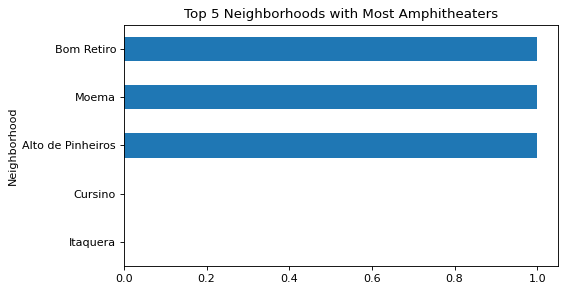

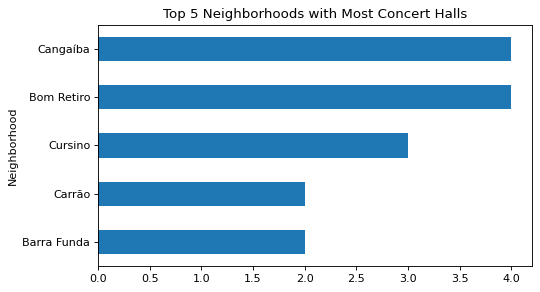

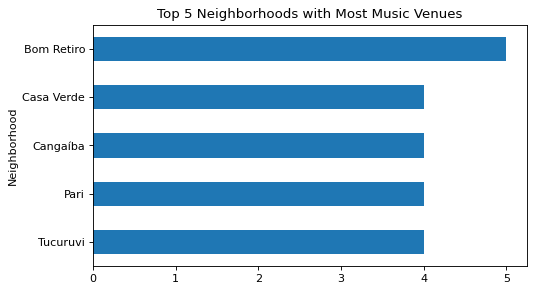

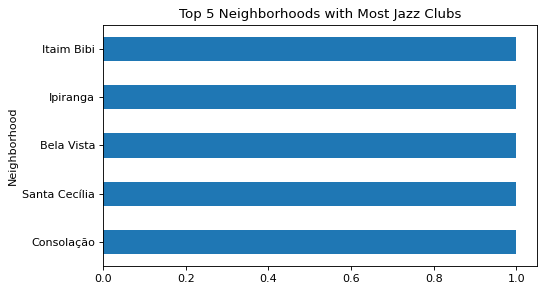

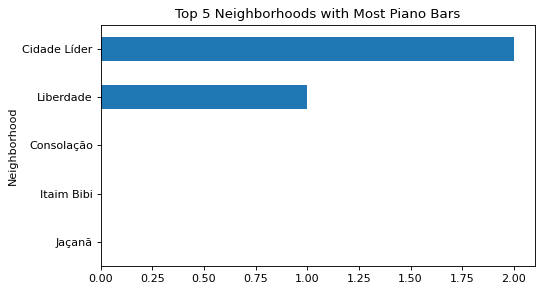

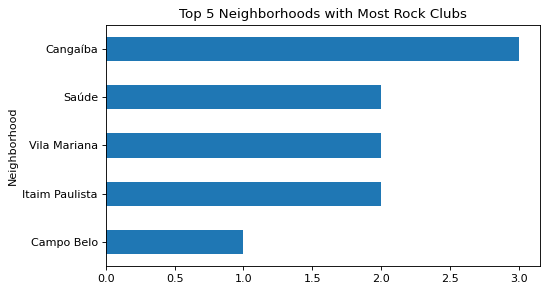

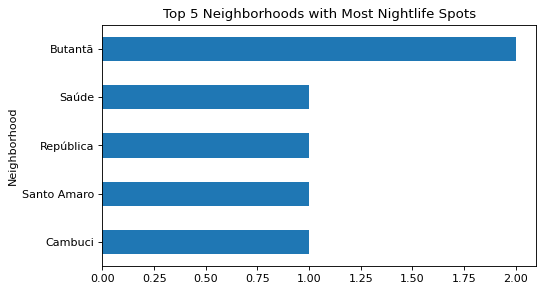

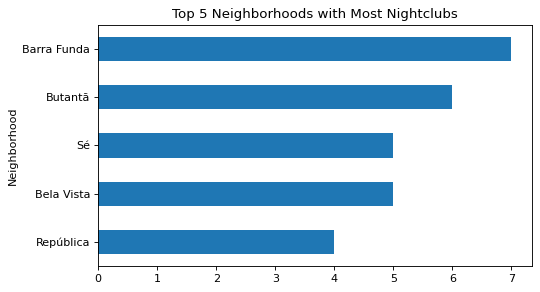

In [ ]:
import matplotlib.pyplot as plt

plot_categories = ['Amphitheater', 'Concert Hall', 'Music Venue', 'Jazz Club', 'Piano Bar', 'Rock Club', 'Nightlife Spot', 'Nightclub']
n = 5
for category in plot_categories:
    plt.figure(num=None, figsize=(7, 4), dpi=80, facecolor='w', edgecolor='k')
    plt.title(f'Top {n} Neighborhoods with Most {category}s')
    top_category_neighborhoods = venue_counts[category].sort_values(ascending=False)[0:n]
    top_category_neighborhoods = top_category_neighborhoods.sort_values(ascending=True)
    top_category_neighborhoods.plot.barh(y=category, rot=0)

###3.1.2 Plotting more data
Let's also plot the distribution of music venues categories.

In [ ]:
venue_totals = {}
for category in ['Amphitheater', 'Concert Hall', 'Music Venue', 'Jazz Club', 'Piano Bar', 'Rock Club', 'Nightlife Spot', 'Nightclub']:
    venue_totals[category] = venue_counts[category].sum()

venue_totals

{'Amphitheater': 3,
 'Concert Hall': 37,
 'Jazz Club': 5,
 'Music Venue': 96,
 'Nightclub': 98,
 'Nightlife Spot': 9,
 'Piano Bar': 3,
 'Rock Club': 33}

In [ ]:
venue_totals_df = pd.DataFrame(list(venue_totals.items()), columns = ['Type of Venue', 'Total'])
venue_totals_df

,Type of Venue,Total
0,Amphitheater,3
1,Concert Hall,37
2,Music Venue,96
3,Jazz Club,5
4,Piano Bar,3
5,Rock Club,33
6,Nightlife Spot,9
7,Nightclub,98


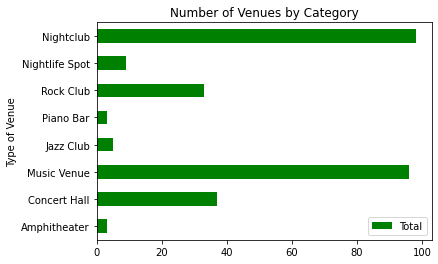

In [ ]:
venue_totals_df.plot.barh(x='Type of Venue', y='Total',
             title='Number of Venues by Category', color='green')

###3.2 Venues mean
Let's calculate the mean for each music venue category in each neighborhood, so we can analyse the frequency of categories and also proceed with the cluster analysis.

In [ ]:
venue_mean = pd.DataFrame()
for category, total in venue_totals.items():
    venue_mean[category] = venue_counts[category].apply(lambda x: x / total)
venue_mean = venue_mean.reindex(sorted(venue_mean.columns), axis=1).reset_index()
venue_mean.head(5)

,Neighborhood,Amphitheater,Concert Hall,Jazz Club,Music Venue,Nightclub,Nightlife Spot,Piano Bar,Rock Club
0,Alto de Pinheiros,0.333333,0.000000,0.0,0.020833,0.010204,0.0,0.0,0.0
1,Anhanguera,0.000000,0.000000,0.0,0.010417,0.000000,0.0,0.0,0.0
2,Aricanduva,0.000000,0.000000,0.0,0.000000,0.010204,0.0,0.0,0.0
3,Artur Alvim,0.000000,0.000000,0.0,0.020833,0.000000,0.0,0.0,0.0
4,Barra Funda,0.000000,0.054054,0.0,0.031250,0.071429,0.0,0.0,0.0


In [ ]:
num_top_venues = 5

for hood in venue_mean['Neighborhood']:
    print("----"+hood+"----")
    temp = venue_mean[venue_mean['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Alto de Pinheiros----
          venue  freq
0  Amphitheater  0.33
1   Music Venue  0.02
2     Nightclub  0.01
3  Concert Hall  0.00
4     Jazz Club  0.00


----Anhanguera----
          venue  freq
0   Music Venue  0.01
1  Amphitheater  0.00
2  Concert Hall  0.00
3     Jazz Club  0.00
4     Nightclub  0.00


----Aricanduva----
          venue  freq
0     Nightclub  0.01
1  Amphitheater  0.00
2  Concert Hall  0.00
3     Jazz Club  0.00
4   Music Venue  0.00


----Artur Alvim----
          venue  freq
0   Music Venue  0.02
1  Amphitheater  0.00
2  Concert Hall  0.00
3     Jazz Club  0.00
4     Nightclub  0.00


----Barra Funda----
          venue  freq
0     Nightclub  0.07
1  Concert Hall  0.05
2   Music Venue  0.03
3  Amphitheater  0.00
4     Jazz Club  0.00


----Bela Vista----
          venue  freq
0     Jazz Club  0.20
1     Nightclub  0.05
2   Music Venue  0.02
3  Amphitheater  0.00
4  Concert Hall  0.00


----Belém----
          venue  freq
0     Nightclub  0.01
1  Amphitheater

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [ ]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = venue_mean['Neighborhood']

for ind in np.arange(venue_mean.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(venue_mean.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Alto de Pinheiros,Amphitheater,Music Venue,Nightclub,Rock Club,Piano Bar
1,Anhanguera,Music Venue,Rock Club,Piano Bar,Nightlife Spot,Nightclub
2,Aricanduva,Nightclub,Rock Club,Piano Bar,Nightlife Spot,Music Venue
3,Artur Alvim,Music Venue,Rock Club,Piano Bar,Nightlife Spot,Nightclub
4,Barra Funda,Nightclub,Concert Hall,Music Venue,Rock Club,Piano Bar


##4. Cluster analysis
Now that our data is cleaned and prepared, let's finally do our cluster analysis. We'll use the elbow method to find out how many clusters we should use for the analysis.

In [ ]:
cluster_data=venue_mean.filter(['Amphitheater', 'Concert Hall', 'Music Venue', 'Jazz Club', 'Piano Bar', 'Rock Club', 'Nightlife Spot', 'Nightclub'], axis = 1)

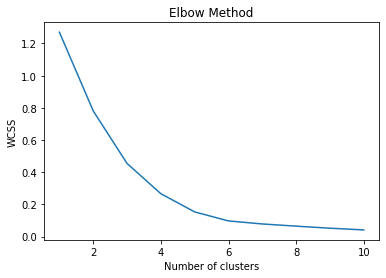

In [ ]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(cluster_data)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

###4.1 Clustering with k-means
We'll be using four clusters in accordance with the elbow method. Let's run the k-means algorithm, then add the cluster labels to our data set.

In [ ]:
# set number of clusters
kclusters = 4

venues_clustering = venue_mean.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venues_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20]

array([3, 0, 0, 0, 0, 2, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

In [ ]:
neighborhoods_venues_sorted.drop(['Cluster Labels'], axis=1, inplace=True)
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [ ]:
neighborhoods_venues_sorted

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,3,Alto de Pinheiros,Amphitheater,Music Venue,Nightclub,Rock Club,Piano Bar
1,0,Anhanguera,Music Venue,Rock Club,Piano Bar,Nightlife Spot,Nightclub
2,0,Aricanduva,Nightclub,Rock Club,Piano Bar,Nightlife Spot,Music Venue
3,0,Artur Alvim,Music Venue,Rock Club,Piano Bar,Nightlife Spot,Nightclub
4,0,Barra Funda,Nightclub,Concert Hall,Music Venue,Rock Club,Piano Bar
...,...,...,...,...,...,...,...
74,0,Vila Matilde,Music Venue,Nightclub,Rock Club,Piano Bar,Nightlife Spot
75,0,Vila Medeiros,Music Venue,Rock Club,Piano Bar,Nightlife Spot,Nightclub
76,0,Vila Prudente,Nightclub,Rock Club,Piano Bar,Nightlife Spot,Music Venue
77,0,Vila Sônia,Nightclub,Music Venue,Rock Club,Piano Bar,Nightlife Spot


###4.1.2 Merging data
Before we can plot the clusters into a map, let's bring to our current data the latitude and longitude values for each neighborhood.

In [ ]:
music_venues_merged = sp_districts

# merge data to add latitude/longitude for each neighborhood
music_venues_merged = music_venues_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Districts')

music_venues_merged.head()

,Districts,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Grajaú,-23.785798,-46.665575,NaN,NaN,NaN,NaN,NaN,NaN
2,Sapopemba,-23.604326,-46.509885,0.0,Rock Club,Music Venue,Nightclub,Piano Bar,Nightlife Spot
3,Jardim Ângela,-23.712246,-46.771206,NaN,NaN,NaN,NaN,NaN,NaN
4,Brasilândia,-23.448272,-46.690269,NaN,NaN,NaN,NaN,NaN,NaN
5,Capão Redondo,-23.658859,-46.767753,0.0,Music Venue,Nightclub,Rock Club,Piano Bar,Nightlife Spot


In [ ]:
music_venues_merged.shape

(96, 9)

###4.1.3 An important parenthesis
As we can see from the dataframe above, some neighborhoods have no cluster labels assigned, nor any music venues categories. This is because we removed all the entries with NaN values in the cleaning step. But now that we brought back the coordinates data, the neighborhoods with missing values were reintroduced into the data set.

The point is, that having no music venues at all might be just as an important information as having venues X or Y. For our final report, this information could bring some insights as well.

So we are now paying a brief attention to these neighborhoods with no music venues at all. Let's put them into a new dataframe and plot the map.

In [ ]:
music_venues_merged[music_venues_merged.isnull().any(axis=1)]

,Districts,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Grajaú,-23.785798,-46.665575,NaN,NaN,NaN,NaN,NaN,NaN
3,Jardim Ângela,-23.712246,-46.771206,NaN,NaN,NaN,NaN,NaN,NaN
4,Brasilândia,-23.448272,-46.690269,NaN,NaN,NaN,NaN,NaN,NaN
11,Cidade Tiradentes,-23.582497,-46.409207,NaN,NaN,NaN,NaN,NaN,NaN
16,Tremembé,-22.957140,-45.547526,NaN,NaN,NaN,NaN,NaN,NaN
20,Vila Curuçá,-23.510151,-46.417893,NaN,NaN,NaN,NaN,NaN,NaN
21,Pedreira,-22.741347,-46.894846,NaN,NaN,NaN,NaN,NaN,NaN
23,Cachoeirinha,-23.449337,-46.663636,NaN,NaN,NaN,NaN,NaN,NaN
26,São Rafael,-23.627159,-46.453241,NaN,NaN,NaN,NaN,NaN,NaN
27,Parelheiros,-23.824791,-46.733078,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data = music_venues_merged[music_venues_merged.isnull().any(axis=1)]
no_music_venues = pd.DataFrame(data, columns=['Districts', 'Latitude', 'Longitude'])
no_music_venues

,Districts,Latitude,Longitude
1,Grajaú,-23.785798,-46.665575
3,Jardim Ângela,-23.712246,-46.771206
4,Brasilândia,-23.448272,-46.690269
11,Cidade Tiradentes,-23.582497,-46.409207
16,Tremembé,-22.957140,-45.547526
20,Vila Curuçá,-23.510151,-46.417893
21,Pedreira,-22.741347,-46.894846
23,Cachoeirinha,-23.449337,-46.663636
26,São Rafael,-23.627159,-46.453241
27,Parelheiros,-23.824791,-46.733078


In [ ]:
# create map of districts with no music venues
map_no_venues = folium.Map(location=[latitude, longitude], zoom_start=11)
 
# add markers to map
for lat, lng, label in zip(no_music_venues['Latitude'], no_music_venues['Longitude'], no_music_venues['Districts']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_no_venues)  
    
map_no_venues

###4.2 Final clustering

Now let's get back to our clusters. Let's drop the neighborhoods with no clusters assigned and finally plot the clusters into a new map.

In [ ]:
final_music_venues = music_venues_merged.dropna(axis = 0, how ='any')
final_music_venues.head()

,Districts,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,Sapopemba,-23.604326,-46.509885,0.0,Rock Club,Music Venue,Nightclub,Piano Bar,Nightlife Spot
5,Capão Redondo,-23.658859,-46.767753,0.0,Music Venue,Nightclub,Rock Club,Piano Bar,Nightlife Spot
6,Jardim São Luís,-23.683573,-46.737762,0.0,Rock Club,Piano Bar,Nightlife Spot,Nightclub,Music Venue
7,Cidade Ademar,-23.673012,-46.655281,0.0,Concert Hall,Nightclub,Rock Club,Piano Bar,Nightlife Spot
8,Itaim Paulista,-23.501765,-46.399609,0.0,Rock Club,Nightclub,Piano Bar,Nightlife Spot,Music Venue


In [ ]:
final_music_venues.shape

(79, 9)

In [ ]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(final_music_venues['Latitude'], final_music_venues['Longitude'], final_music_venues['Districts'], final_music_venues['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

###4.2.3 Examining clusters

Let's see how we can profile each of the four clusters of our analysis.

####Cluster 0: Music Mixing
A diverse variety of music venues in a large group of neighborhoods.

In [ ]:
final_music_venues.loc[final_music_venues['Cluster Labels'] == 0, final_music_venues.columns[[0] + list(range(4, final_music_venues.shape[1]))]]

,Districts,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,Sapopemba,Rock Club,Music Venue,Nightclub,Piano Bar,Nightlife Spot
5,Capão Redondo,Music Venue,Nightclub,Rock Club,Piano Bar,Nightlife Spot
6,Jardim São Luís,Rock Club,Piano Bar,Nightlife Spot,Nightclub,Music Venue
7,Cidade Ademar,Concert Hall,Nightclub,Rock Club,Piano Bar,Nightlife Spot
8,Itaim Paulista,Rock Club,Nightclub,Piano Bar,Nightlife Spot,Music Venue
...,...,...,...,...,...,...
91,Brás,Concert Hall,Music Venue,Rock Club,Piano Bar,Nightlife Spot
92,Jaguara,Nightclub,Rock Club,Piano Bar,Nightlife Spot,Music Venue
93,Sé,Nightlife Spot,Nightclub,Music Venue,Rock Club,Piano Bar
94,Pari,Music Venue,Nightclub,Rock Club,Piano Bar,Nightlife Spot


####Cluster 1: A bit of piano
A less common venue category shines in this cluster.

In [ ]:
final_music_venues.loc[final_music_venues['Cluster Labels'] == 1, final_music_venues.columns[[0] + list(range(4, final_music_venues.shape[1]))]]

,Districts,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
30,Cidade Líder,Piano Bar,Rock Club,Nightlife Spot,Nightclub,Music Venue
76,Liberdade,Piano Bar,Concert Hall,Music Venue,Rock Club,Nightlife Spot


####Cluster 2: All That Jazz
An interesting concentration of jazz clubs.

In [ ]:
final_music_venues.loc[final_music_venues['Cluster Labels'] == 2, final_music_venues.columns[[0] + list(range(4, final_music_venues.shape[1]))]]

,Districts,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
50,Ipiranga,Jazz Club,Music Venue,Rock Club,Piano Bar,Nightlife Spot
62,Itaim Bibi,Jazz Club,Rock Club,Piano Bar,Nightlife Spot,Nightclub
70,Santa Cecília,Jazz Club,Concert Hall,Nightclub,Rock Club,Piano Bar
77,Bela Vista,Jazz Club,Nightclub,Music Venue,Rock Club,Piano Bar
81,Consolação,Jazz Club,Rock Club,Piano Bar,Nightlife Spot,Nightclub


####Cluster 3: For the crowds
Large crowds can find their place here, in both amphitheaters and concert halls.

In [ ]:
final_music_venues.loc[final_music_venues['Cluster Labels'] == 3, final_music_venues.columns[[0] + list(range(4, final_music_venues.shape[1]))]]

,Districts,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
67,Moema,Amphitheater,Concert Hall,Music Venue,Nightclub,Rock Club
84,Alto de Pinheiros,Amphitheater,Music Venue,Nightclub,Rock Club,Piano Bar
90,Bom Retiro,Amphitheater,Concert Hall,Music Venue,Nightclub,Rock Club
